# Importación de librerías y carga de datos

In [1]:
"""
Modulo de entrenamiento para diferentes pipelines de ML para el
entrenamiento utilizando los datasets creados. El flujo es capaz de 
generalizar en la mayoría de los casos y únicamente es necesario
realizar modificaciones en la ruta a los datos.

"""
import os
import pandas as pd 
import seaborn as sns                                                   
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, \
                                    cross_val_score, \
                                    learning_curve, \
                                    RandomizedSearchCV, \
                                    GridSearchCV
from sklearn.inspection import permutation_importance
import numpy as np
from sklearn.svm import SVC
from sklearn import datasets, metrics
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
from boruta import BorutaPy
from tpot import TPOTClassifier
import dataframe_image as dfi
from keras.models import Sequential,load_model,model_from_json
import itertools
import joblib  
from sklearn.metrics import confusion_matrix, recall_score, precision_score


path_santiago = r'C:\Users\santi\Universidad de Antioquia\VALERIA CADAVID CASTRO - Resultados_Armonizacion_BD'
path_veronica = r'C:\Users\veroh\OneDrive - Universidad de Antioquia\Articulo análisis longitudinal\Resultados_Armonizacion_BD'
path_save =r'C:\Users\veroh\OneDrive - Universidad de Antioquia\Articulo análisis longitudinal\Resultados_Armonizacion_BD\Graficos_ML'
name = 'neuroHarmonize_G1'
space = 'roi'
path_plot = path_save + '/' + name+'_'+space
os.makedirs(path_plot,exist_ok=True)

In [2]:
# compute precision and recall
def computerprecision(test_label,classes_x):
  precision_test = precision_score(test_label,classes_x)
  recall_test = recall_score(test_label, classes_x)
  f1_test = 2 * (precision_test * recall_test) / (precision_test + recall_test)
  print( 'Precision: ', precision_test, '\n', 'Recall: ', recall_test,'\n', 'F1-score:', f1_test )

In [3]:
def plot_confusion_matrix(path_plot,cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap='winter'):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig(path_plot+'/'+'confusion_matrix'+'_'+space+'.png')

In [4]:
path = path_veronica

In [5]:
modelos = {}
acc_per_feature = []
std_per_feature = []

In [6]:
data = pd.read_feather(r'{path}\Datosparaorganizardataframes\Data_complete_{space}_{name}.feather'
                       .format(path=path,space=space,name=name))

In [7]:
data

,power_F_Delta,power_C_Delta,power_PO_Delta,power_T_Delta,power_F_Theta,power_C_Theta,power_PO_Theta,power_T_Theta,power_F_Alpha-1,power_C_Alpha-1,...,crossfreq_PO_Mbeta3_Gamma,crossfreq_PO_Mgamma_Gamma,crossfreq_T_Mdelta_Gamma,crossfreq_T_Mtheta_Gamma,crossfreq_T_Malpha-1_Gamma,crossfreq_T_Malpha-2_Gamma,crossfreq_T_Mbeta1_Gamma,crossfreq_T_Mbeta2_Gamma,crossfreq_T_Mbeta3_Gamma,crossfreq_T_Mgamma_Gamma
0,0.257264,0.208360,0.164770,0.116284,0.052460,0.058447,0.044141,0.041779,0.096323,0.131752,...,0.123104,0.107148,88.128662,2.392972,0.293704,0.171698,0.296932,0.074287,0.130953,0.150222
1,0.245156,0.227453,0.154873,0.187236,0.122169,0.129600,0.105197,0.109494,0.236651,0.242781,...,0.162290,0.105520,88.170200,3.096258,0.379186,0.179403,0.292925,0.073689,0.113797,0.085067
2,0.347421,0.248157,0.184846,0.138805,0.112601,0.107649,0.066297,0.056254,0.070838,0.081728,...,0.108659,0.080895,87.791073,3.029991,0.380496,0.211489,0.285365,0.070744,0.125326,0.104291
3,0.116981,0.087202,0.099526,0.109961,0.142887,0.110846,0.134618,0.152668,0.226418,0.261000,...,0.191969,0.151820,84.204324,4.860626,0.547769,0.277746,0.339173,0.086776,0.130904,0.093567
4,0.274468,0.287189,0.219742,0.297252,0.103932,0.122704,0.110995,0.117885,0.153400,0.148707,...,0.075013,0.050311,90.944880,2.428511,0.309400,0.147536,0.190028,0.047138,0.070780,0.056945
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,0.228395,0.268958,0.162858,0.257416,0.110504,0.119700,0.102501,0.122693,0.365758,0.306458,...,0.114376,0.092622,89.730174,2.811756,0.370215,0.168397,0.205219,0.055113,0.076234,0.060291
140,0.229305,0.192587,0.155159,0.190790,0.091327,0.095228,0.087517,0.107190,0.297647,0.259852,...,0.094639,0.072094,90.693951,2.236288,0.326020,0.196579,0.289628,0.063894,0.080708,0.059649
141,0.093953,0.101137,0.078749,0.101163,0.064798,0.078456,0.068615,0.070213,0.506783,0.480568,...,0.237438,0.182025,83.724087,3.224268,0.632486,0.384759,0.424279,0.118382,0.209430,0.178933
142,0.294263,0.174868,0.118921,0.163093,0.108368,0.079374,0.079310,0.082564,0.147328,0.218065,...,0.121002,0.095972,86.452414,3.019158,0.369140,0.263825,0.454177,0.093833,0.149810,0.131213


In [8]:
print(f'sujetos: {data.shape[0]} | caracteristicas: {data.shape[1]}')

sujetos: 144 | caracteristicas: 396


# Preprocesamiento

## Análisis exploratorio de datos

In [9]:
for group in data['group'].unique():
        
        print('{} : {}'.format(group, (data['group']==group).sum()))

G1 : 48
Control : 96


In [10]:
data.describe()

,power_F_Delta,power_C_Delta,power_PO_Delta,power_T_Delta,power_F_Theta,power_C_Theta,power_PO_Theta,power_T_Theta,power_F_Alpha-1,power_C_Alpha-1,...,crossfreq_PO_Mbeta3_Gamma,crossfreq_PO_Mgamma_Gamma,crossfreq_T_Mdelta_Gamma,crossfreq_T_Mtheta_Gamma,crossfreq_T_Malpha-1_Gamma,crossfreq_T_Malpha-2_Gamma,crossfreq_T_Mbeta1_Gamma,crossfreq_T_Mbeta2_Gamma,crossfreq_T_Mbeta3_Gamma,crossfreq_T_Mgamma_Gamma
count,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000,...,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000
mean,0.222604,0.188404,0.147231,0.183740,0.108896,0.106128,0.099140,0.101733,0.250278,0.252634,...,0.138180,0.105476,87.189985,3.097509,0.421249,0.225733,0.337129,0.082914,0.130672,0.113559
std,0.087908,0.076156,0.066483,0.076574,0.048967,0.044918,0.051005,0.048503,0.131070,0.118404,...,0.057408,0.055450,3.492833,0.656414,0.118388,0.079524,0.140564,0.033824,0.060645,0.077091
min,0.080580,0.068841,0.049525,0.063650,0.040299,0.042023,0.030464,0.035308,0.048427,0.051036,...,0.050770,0.032323,75.424663,1.761502,0.154676,0.074789,0.086766,0.027968,0.037182,0.026341
25%,0.158888,0.130630,0.100458,0.130681,0.078769,0.077803,0.065721,0.071188,0.142541,0.148633,...,0.104751,0.074551,84.920173,2.648744,0.331496,0.159997,0.228486,0.056927,0.090640,0.070375
50%,0.210376,0.181549,0.134622,0.172105,0.095583,0.091822,0.082848,0.087862,0.245177,0.245228,...,0.125449,0.092292,88.126858,3.001842,0.390008,0.210459,0.311468,0.076582,0.115426,0.090321
75%,0.282454,0.230869,0.176451,0.225921,0.126159,0.124540,0.119257,0.120022,0.360674,0.341177,...,0.156606,0.117517,89.310495,3.546374,0.490536,0.275778,0.390623,0.094125,0.152325,0.123592
max,0.461104,0.452270,0.385196,0.539973,0.343032,0.278224,0.323294,0.328165,0.596052,0.543483,...,0.345437,0.378856,96.306059,5.152678,0.736684,0.465182,0.833434,0.210499,0.382014,0.538299


In [11]:
data.groupby(by='group').describe().T

group                             Control         G1
power_F_Delta            count  96.000000  48.000000
                         mean    0.229006   0.209801
                         std     0.091031   0.080697
                         min     0.080580   0.081769
                         25%     0.161662   0.152090
...                                   ...        ...
crossfreq_T_Mgamma_Gamma min     0.026341   0.047562
                         25%     0.069229   0.073640
                         50%     0.083768   0.102915
                         75%     0.122489   0.130971
                         max     0.476849   0.538299

[3120 rows x 2 columns]

In [12]:
# eliminación de columnas con datos faltantes

for column in data.columns:

    if data[column].isna().sum() != 0:

        print('{} : {}'.format(column, (data[column].isna().sum())))
        data.drop(column, axis=1, inplace=True)

MM_total : 42
FAS_F : 75
FAS_S : 75
FAS_A : 75
education : 42


In [13]:
print(f'sujetos: {data.shape[0]} | caracteristicas: {data.shape[1]}')

sujetos: 144 | caracteristicas: 391


In [14]:
# Se mapean las clases 

clases_mapeadas = {label:idx for idx,label  
                   in enumerate(np.unique(data['group']))}

data.loc[:,'group'] = data.loc[:,'group'].map(clases_mapeadas) 
print(clases_mapeadas)

{'Control': 0, 'G1': 1}


C:\Users\veroh\AppData\Local\Temp\ipykernel_155728\383920285.py:6: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data.loc[:,'group'] = data.loc[:,'group'].map(clases_mapeadas)


In [15]:
print(data.dtypes.unique())

[dtype('float64') dtype('O') dtype('int64')]


In [16]:
data.select_dtypes('O')

,database,participant_id,visit,condition,sex
0,BIOMARCADORES,sub-G1024,V0,CE,M
1,BIOMARCADORES,sub-G1023,V0,CE,F
2,BIOMARCADORES,sub-G1022,V0,CE,F
3,BIOMARCADORES,sub-G1021,V0,CE,F
4,BIOMARCADORES,sub-G1019,V0,CE,F
...,...,...,...,...,...
139,CHBMP,sub-CBM00158,V0,protmap,M
140,CHBMP,sub-CBM00156,V0,protmap,F
141,CHBMP,sub-CBM00147,V0,protmap,F
142,CHBMP,sub-CBM00283,V0,protmap,F


In [17]:
data.groupby(by='sex').describe().T

sex                                     F          M
power_F_Delta            count  79.000000  65.000000
                         mean    0.222519   0.222707
                         std     0.094621   0.079720
                         min     0.080680   0.080580
                         25%     0.149554   0.170669
...                                   ...        ...
crossfreq_T_Mgamma_Gamma min     0.036947   0.026341
                         25%     0.073652   0.066258
                         50%     0.097255   0.083363
                         75%     0.131900   0.114578
                         max     0.411633   0.538299

[3088 rows x 2 columns]

In [18]:
sexo_mapeado = {label:idx for idx,label
                in enumerate(np.unique(data['sex']))}

data.loc[:,'sex'] = data.loc[:,'sex'].map(sexo_mapeado) 
print(sexo_mapeado)

{'F': 0, 'M': 1}


C:\Users\veroh\AppData\Local\Temp\ipykernel_155728\2216644689.py:4: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data.loc[:,'sex'] = data.loc[:,'sex'].map(sexo_mapeado)


In [19]:
# data pasa a ser el arreglo únicamente con los datos númericos

numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

data = data.select_dtypes(include=numerics)

data.shape

(144, 387)

In [20]:
# Se elimina la columna, para ponerla al final

target = data.pop('group')
data.insert(len(data.columns), target.name, target)

## Selección de caracteristicas

### Creación de datasets de entrenamiento y test

In [21]:
X = data.values[:,:-1]
y = data.values[:,-1]
print(X.shape)
print(y.shape)

(144, 386)
(144,)


In [22]:
X_train, X_test, y_train, y_test = train_test_split(                            
    X, # Valores de X
    y, # Valores de Y
    test_size=0.2, # Test de 20%
    random_state=1, # Semilla
    stratify=data.values[:,-1]) # que se mantenga la proporcion en la división

### Mapa de calor de correlación

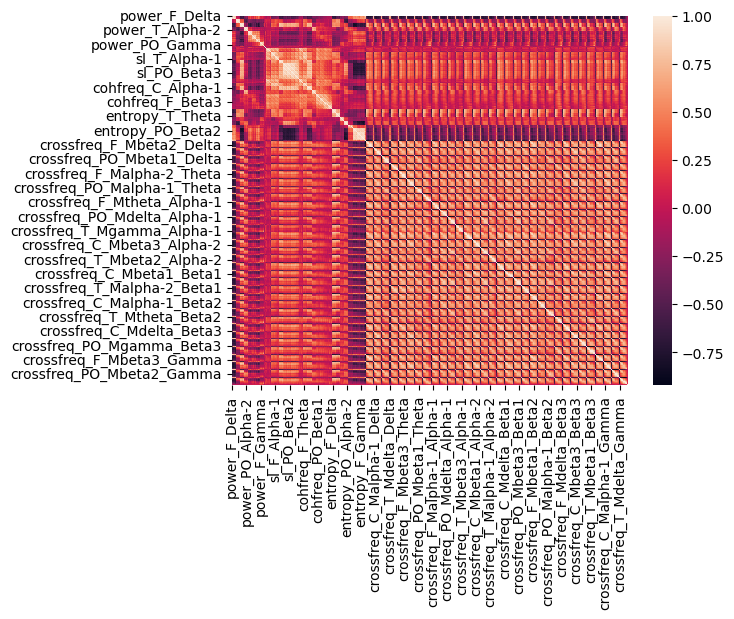

In [23]:
sns.heatmap(data.corr())
plt.savefig(path_plot+'/'+'correlation'+'_'+space+'.png')

### Árboles de decisión (Grid Search)

In [24]:
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 2000, num = 30)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
criterion = ['gini',  'entropy', 'log_loss']

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
               'criterion': criterion
               }

In [25]:
forestclf_grid = RandomForestClassifier()

rf_random = RandomizedSearchCV(
                              estimator=forestclf_grid,
                              param_distributions=random_grid,
                              n_iter=100,
                              cv=10,
                              verbose=2,
                              random_state=10,
                              n_jobs=-1
                              )

rf_random.fit(X_train, y_train)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


RandomizedSearchCV(cv=10, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'criterion': ['gini', 'entropy',
                                                      'log_loss'],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 165, 231, 296,
                                                         362, 427, 493, 558,
                                                         624, 689, 755, 820,
                                                         886, 951, 1017, 1082,
                                                         1148, 1213, 1279, 1344,
                                                         1410, 1475, 1541, 1606,
                                                         1672, 1737, 1803, 1868,
                                                         1934, 2000]},
                   random_state=10, verbose=2)

In [26]:
best_selected = rf_random.best_estimator_

In [27]:
GS_fitted = best_selected.fit(X_train, y_train)
modelos['GridSerach'] = GS_fitted

In [28]:
predicted = GS_fitted.predict(X_test)

In [29]:
print(
    f"Classification report for classifier {GS_fitted}:\n"
    f"{metrics.classification_report(y_test, predicted)}\n"
    )

Classification report for classifier RandomForestClassifier(criterion='entropy', max_depth=90, min_samples_leaf=4,
                       min_samples_split=10, n_estimators=624):
              precision    recall  f1-score   support

         0.0       0.65      0.89      0.76        19
         1.0       0.33      0.10      0.15        10

    accuracy                           0.62        29
   macro avg       0.49      0.50      0.45        29
weighted avg       0.54      0.62      0.55        29




In [30]:
dataframe_metrics = metrics.classification_report(y_test, predicted, output_dict=True)
dataframe_metrics = pd.DataFrame(dataframe_metrics).T
dfi.export(dataframe_metrics, path_plot+'/'+'metrics'+'_'+space+'.png')

C:\Program Files\Google\Chrome\Application\chrome.exe


In [31]:
scores = cross_val_score(
                        estimator=GS_fitted,
                        X=X_train,
                        y=y_train,
                        cv=10,
                        n_jobs=-1
                        )

In [32]:
print('CV accuracy scores: %s' % scores)

CV accuracy scores: [0.66666667 0.66666667 0.66666667 0.66666667 0.66666667 0.54545455
 0.81818182 0.54545455 0.72727273 0.63636364]


In [33]:
print('\nCV accuracy: %.3f +/- %.3f' %
    (np.mean(scores), np.std(scores)))

acc_per_feature.append(np.mean(scores))
std_per_feature.append(np.std(scores))


CV accuracy: 0.661 +/- 0.075


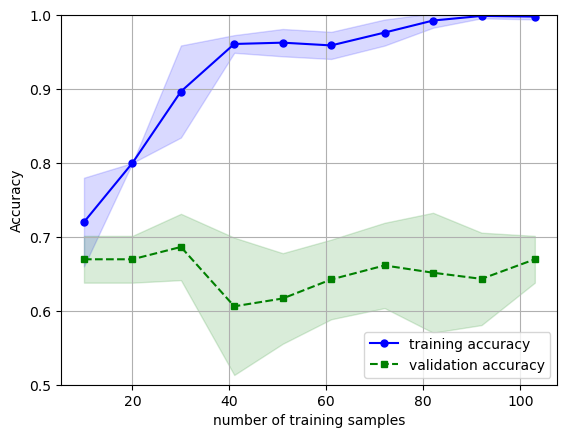

In [34]:
train_sizes, train_scores, test_scores = \
    learning_curve(
                  estimator=GS_fitted,
                  X=X_train,
                  y=y_train,
                  train_sizes=np.linspace(0.1, 1, 10),
                  cv=10,
                  n_jobs=-1
                  )
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(
        train_sizes,
        train_mean,
        color='blue',
        marker='o',
        markersize=5,
        label='training accuracy'
        )

plt.fill_between(
                train_sizes,
                train_mean + train_std,
                train_mean - train_std,
                alpha=0.15,
                color='blue'
                )

plt.plot(
        train_sizes,
        test_mean,
        color='green',
        linestyle='--',
        marker='s',
        markersize=5,
        label='validation accuracy'
        )

plt.fill_between(
                train_sizes,
                test_mean + test_std,
                test_mean - test_std,
                alpha=0.15,
                color='green'
                )

plt.grid()
plt.xlabel('number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.5, 1.0])
plt.savefig(path_plot+'/'+'validation_GridSearch'+'_'+space+'.png')
plt.show()

### Árboles de decisión (Boruta)

In [35]:
feat_selector = BorutaPy(
                        verbose=2,
                        estimator=best_selected,
                        max_iter=100,
                        random_state=10
                        )

In [36]:
feat_selector.fit(X_train, y_train)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	386
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	386
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	386
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	386
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	386
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	386
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	386
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	0
Tentative: 	5
Rejected: 	381
Iteration: 	9 / 100
Confirmed: 	1
Tentative: 	4
Rejected: 	381
Iteration: 	10 / 100
Confirmed: 	1
Tentative: 	4
Rejected: 	381
Iteration: 	11 / 100
Confirmed: 	1
Tentative: 	4
Rejected: 	381
Iteration: 	12 / 100
Confirmed: 	1
Tentative: 	4
Rejected: 	381
Iteration: 	13 / 100
Confirmed: 	1
Tentative: 	4
Rejected: 	381
Iteration: 	14 / 100
Confirmed: 	1
Tentative: 	4
Rejected: 	381
Iteration: 	15 / 100
Confirmed: 	1
Tentative: 	4
Rejected: 	381
Iteration: 	16 / 100
Confirmed: 	1
Tentative: 	4


BorutaPy(estimator=RandomForestClassifier(criterion='entropy', max_depth=90,
                                          min_samples_leaf=4,
                                          min_samples_split=10,
                                          n_estimators=1000,
                                          random_state=RandomState(MT19937) at 0x209058B5240),
         random_state=RandomState(MT19937) at 0x209058B5240, verbose=2)

In [37]:
selected_features = []
print("\n------Support and Ranking for each feature------")
for i in range(len(feat_selector.support_)):
    if feat_selector.support_[i]:
        print("Passes the test: ", data.columns[i],
              " - Ranking: ", feat_selector.ranking_[i])
        selected_features.append(data.columns[i])


------Support and Ranking for each feature------
Passes the test:  power_F_Gamma  - Ranking:  1
Passes the test:  power_C_Gamma  - Ranking:  1
Passes the test:  power_PO_Gamma  - Ranking:  1
Passes the test:  power_T_Gamma  - Ranking:  1
Passes the test:  cohfreq_C_Beta1  - Ranking:  1


In [38]:
X_transform = feat_selector.transform(X_train)

In [39]:
boruta_fitted = best_selected.fit(X_transform, y_train)
modelos['Boruta'] = boruta_fitted

In [40]:
selected_features = [data.columns.get_loc(c) for c in selected_features if c in data]
selected_features

[28, 29, 30, 31, 83]

In [41]:
predicted = boruta_fitted.predict(X_test[:,selected_features])

In [42]:
print(
    f"Classification report for classifier {boruta_fitted}:\n"
    f"{metrics.classification_report(y_test, predicted)}\n"
)

Classification report for classifier RandomForestClassifier(criterion='entropy', max_depth=90, min_samples_leaf=4,
                       min_samples_split=10, n_estimators=1000,
                       random_state=RandomState(MT19937) at 0x209058B5240):
              precision    recall  f1-score   support

         0.0       0.76      0.84      0.80        19
         1.0       0.62      0.50      0.56        10

    accuracy                           0.72        29
   macro avg       0.69      0.67      0.68        29
weighted avg       0.71      0.72      0.72        29




In [43]:
dataframe_metrics = metrics.classification_report(y_test, predicted, output_dict=True)
dataframe_metrics = pd.DataFrame(dataframe_metrics).T
dfi.export(dataframe_metrics, path_plot+'/'+'metrics_boruta'+'_'+space+'.png')

C:\Program Files\Google\Chrome\Application\chrome.exe


In [44]:
scores = cross_val_score(estimator=boruta_fitted,
                        X=X_transform,
                        y=y_train,
                        cv=10,
                        n_jobs=-1)

In [45]:
print('CV accuracy scores: %s' % scores)

CV accuracy scores: [0.83333333 0.66666667 0.83333333 0.66666667 0.75       0.63636364
 0.90909091 0.63636364 1.         0.63636364]


In [46]:
print('\nCV accuracy: %.3f +/- %.3f' %
    (np.mean(scores), np.std(scores)))


acc_per_feature.append(np.mean(scores))
std_per_feature.append(np.std(scores))


CV accuracy: 0.757 +/- 0.124


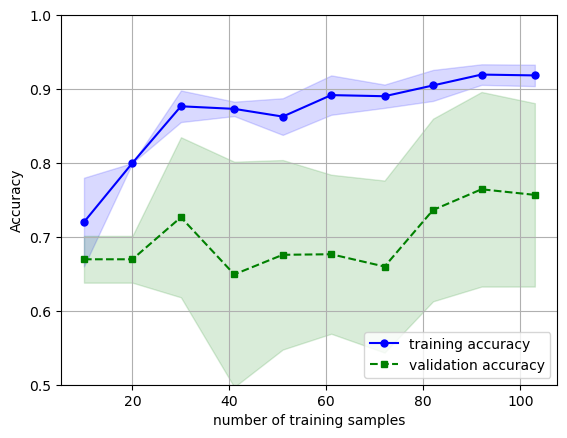

In [47]:
train_sizes, train_scores, test_scores = \
    learning_curve(
                  estimator=boruta_fitted,
                  X=X_transform,
                  y=y_train,
                  train_sizes=np.linspace(0.1, 1, 10),
                  cv=10,
                  n_jobs=-1
                  )
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(
        train_sizes,
        train_mean,
        color='blue',
        marker='o',
        markersize=5,
        label='training accuracy'
        )

plt.fill_between(
                train_sizes,
                train_mean + train_std,
                train_mean - train_std,
                alpha=0.15,
                color='blue'
                )

plt.plot(
        train_sizes,
        test_mean,
        color='green',
        linestyle='--',
        marker='s',
        markersize=5,
        label='validation accuracy'
        )

plt.fill_between(
                train_sizes,
                test_mean + test_std,
                test_mean - test_std,
                alpha=0.15,
                color='green'
                )

plt.grid()
plt.xlabel('number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.5, 1.0])
plt.savefig(path_plot+'/'+'validation_Boruta'+'_'+space+'.png')
plt.show()

### Selección de caracteristicas con árboles de decisión

 1) power_T_Gamma                  0.029207
 2) power_F_Gamma                  0.019113
 3) power_C_Gamma                  0.016966
 4) power_PO_Gamma                 0.014532
 5) cohfreq_C_Beta1                0.012580
 6) sl_PO_Theta                    0.010993
 7) sl_C_Theta                     0.008003
 8) sl_T_Alpha-1                   0.007355
 9) crossfreq_T_Mgamma_Alpha-1     0.006623
10) crossfreq_PO_Mbeta1_Alpha-2    0.006576
11) sl_T_Theta                     0.006555
12) cohfreq_C_Beta3                0.006546
13) cohfreq_C_Delta                0.006442
14) crossfreq_PO_Mbeta3_Theta      0.006291
15) crossfreq_F_Mdelta_Beta3       0.006289
16) crossfreq_PO_Mbeta2_Alpha-2    0.006027
17) entropy_PO_Alpha-1             0.006017
18) cohfreq_T_Delta                0.005851
19) crossfreq_PO_Mbeta1_Beta2      0.005799
20) crossfreq_T_Mgamma_Beta2       0.005707
21) cohfreq_F_Beta3                0.005536
22) crossfreq_F_Mbeta1_Beta3       0.005485
23) crossfreq_T_Mgamma_Beta3    

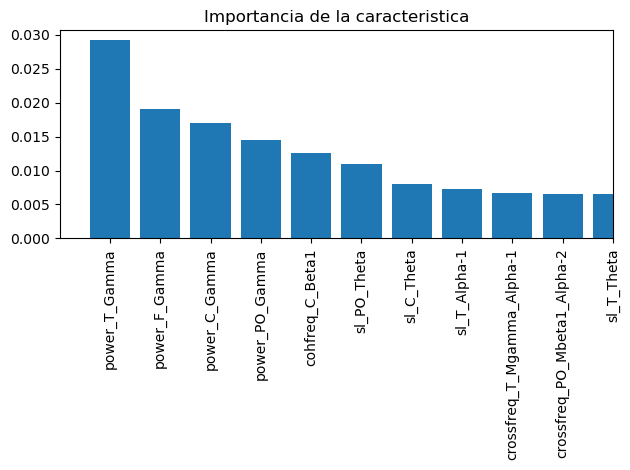

In [48]:
nombres_columnas = data.columns[:-1]
best_selected.fit(X_train, y_train)
features_scores = best_selected.feature_importances_
features_scores
index = np.argsort(features_scores)[::-1]
sorted_names = []

for f in range(X_train.shape[1]):

    sorted_names.append(nombres_columnas[index[f]])
    print("%2d) %-*s %f" % (f + 1, 30,
                        nombres_columnas[index[f]],
                        features_scores[index[f]]))
    
plt.title('Importancia de la caracteristica')

plt.bar(range(X_train.shape[1]),
    features_scores[index],
    align='center')

plt.xticks(range(X_train.shape[1]),
    nombres_columnas[index],
    rotation=90)

plt.xlim([-1, 10])

plt.tight_layout()

plt.show()

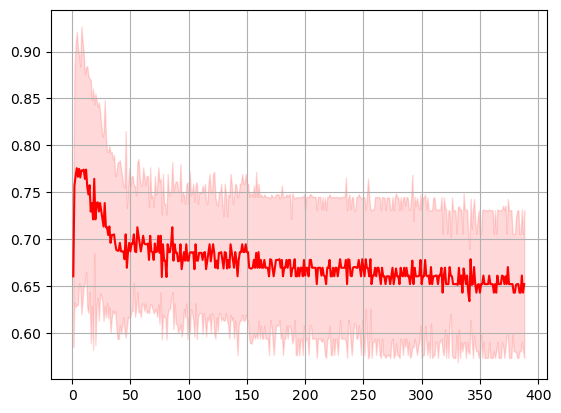

In [49]:
for index, feature_name in enumerate(sorted_names,start=1):

    input_features_names = sorted_names[:index]
    input_features_index = [data.columns.get_loc(c) for c 
                      in input_features_names if c in data]
    feature_model = best_selected.fit(X_train[:, input_features_index], y_train)
    scores = cross_val_score(
                        estimator=feature_model,
                        X=X_train[:, input_features_index],
                        y=y_train,
                        cv=10,
                        n_jobs=-1
                        )
    
  
    modelos['number_features_' + str(index)] = feature_model
    acc_per_feature.append(np.mean(scores))
    std_per_feature.append(np.std(scores))


#plt.plot(
#        range(1, len(sorted_names)),
#        acc_per_feature,
#        color='red'
#        ) 
#
#plt.fill_between(
#                range(1, len(sorted_names)),
#                np.array(acc_per_feature) + np.array(std_per_feature),
#                np.array(acc_per_feature) - np.array(std_per_feature),
#                alpha=0.15,
#                color='red'
#                )

plt.plot(
        range(1, len(acc_per_feature)+1),
        acc_per_feature,
        color='red'
        ) 

plt.fill_between(
                range(1, len(acc_per_feature)+1),
                np.array(acc_per_feature) + np.array(std_per_feature),
                np.array(acc_per_feature) - np.array(std_per_feature),
                alpha=0.15,
                color='red'
                )

plt.grid()
plt.savefig(path_plot+'/'+'features_plot'+'_'+space+'.png')
plt.show()


In [50]:
pos_model = np.argsort(acc_per_feature)[-1]
best_model = list(modelos.keys())[pos_model]
best_model

'number_features_2'

In [51]:
joblib.dump(modelos[best_model], path_plot+'/'+'modelo_entrenado.pkl') # Guardo el modelo.

['C:\\Users\\veroh\\OneDrive - Universidad de Antioquia\\Articulo análisis longitudinal\\Resultados_Armonizacion_BD\\Graficos_ML/neuroHarmonize_G1_roi/modelo_entrenado.pkl']

In [52]:
# Guardar mejore carateristicas
best_features=sorted_names[:pos_model]
mi_path = path_plot+'/'+"best_features.txt"
f = open(mi_path, 'w')

for i in best_features:
    f.write(i+'\n')
f.close()

In [53]:
new_data = pd.DataFrame()
for i in range(0,len(data.columns)):
    for j in range(0,len(best_features)):
        if data.columns[i] == best_features[j]:
            new_data[best_features[j]] = data[best_features[j]]


In [54]:
new_name = 'Data_complete_randomforest'+space+'_'+name
new_data.reset_index(drop=True).to_feather('{path}\Datosparaorganizardataframes\ML\{name}.feather'.format(path=path,name=new_name))
            

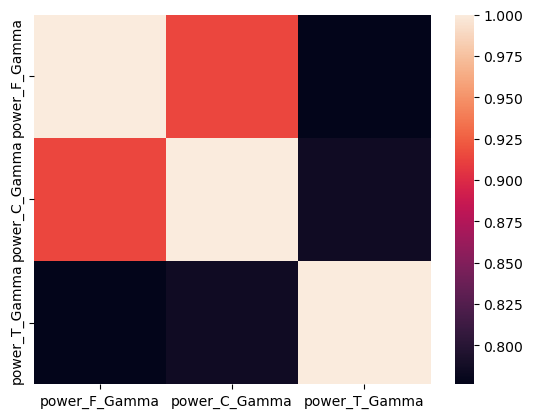

In [55]:
sns.heatmap(new_data.corr())
plt.savefig(path_plot+'/'+'correlation_randomforest'+'_'+space+'.png')

In [56]:
selected_best_features = [new_data.columns.get_loc(c) for c in best_features if c in new_data]
selected_best_features

[2, 0, 1]

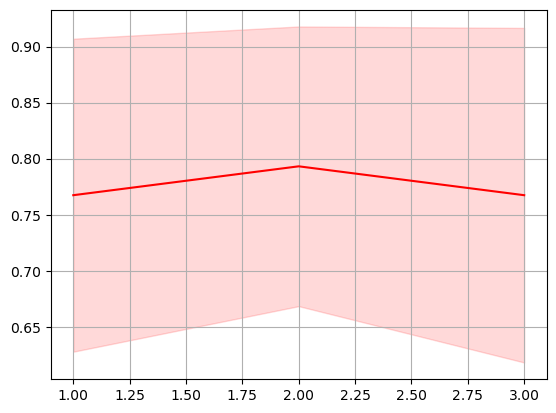

In [57]:
acc = []
std = []
m=[]
for index, feature_name in enumerate(best_features,start=1):

    input_features_best = best_features[:index]
    input_best_index = [data.columns.get_loc(c) for c 
                      in input_features_best if c in data]
    fbest_model = best_selected.fit(X_train[:, input_best_index], y_train)
    scores_best = cross_val_score(
                        estimator=fbest_model,
                        X=X_train[:, input_best_index],
                        y=y_train,
                        cv=10,
                        n_jobs=-1
                        )
    
  
    #m['number_features_BEST' + str(index)] = fbest_model
    acc.append(np.mean(scores_best))
    std.append(np.std(scores_best))

plt.plot(
        range(1, len(acc)+1),
        acc,
        color='red'
        ) 

plt.fill_between(
                range(1, len(acc)+1),
                np.array(acc) + np.array(std),
                np.array(acc) - np.array(std),
                alpha=0.15,
                color='red'
                )

plt.grid()
plt.savefig(path_plot+'/'+'features_plot_best'+'_'+space+'.png')
plt.show()

In [58]:
print(acc[-1])
print(std[-1])

0.7674242424242423
0.14918857665705734


In [59]:
predicted = fbest_model.predict(X_test[:,input_best_index])
classes_x=(predicted >= 0.5).astype(int)
computerprecision(y_test,classes_x)

Precision:  0.6666666666666666 
 Recall:  0.6 
 F1-score: 0.631578947368421


Confusion matrix, without normalization
[[16  3]
 [ 4  6]]


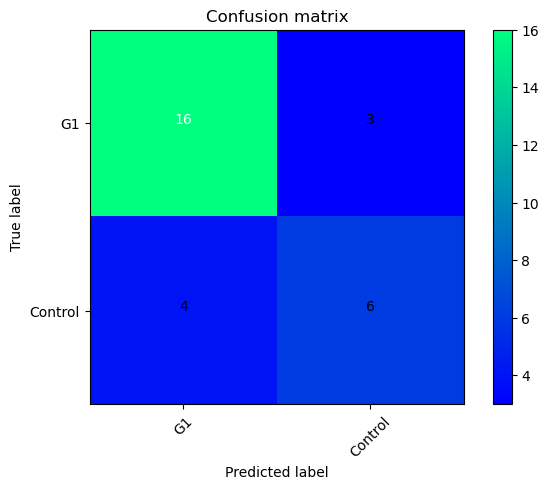

In [60]:
class_names=['G1','Control']
cm_test = confusion_matrix(y_test,classes_x)
plot_confusion_matrix(path_plot,cm_test,classes=class_names,title='Confusion matrix')

In [60]:
train_sizes, train_scores, test_scores = \
    learning_curve(
                  estimator=modelos[best_model],
                  X=X_test[selected_best_features],## Revisar
                  y=y_train[selected_best_features],
                  train_sizes=np.linspace(0.1, 1, 10),
                  cv=10,
                  n_jobs=-1
                  )
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)# test_score
test_std = np.std(test_scores, axis=1)

plt.plot(
        train_sizes,
        train_mean,
        color='blue',
        marker='o',
        markersize=5,
        label='training accuracy'
        )

plt.fill_between(
                train_sizes,
                train_mean + train_std,
                train_mean - train_std,
                alpha=0.15,
                color='blue'
                )

plt.plot(
        train_sizes,
        test_mean,
        color='green',
        linestyle='--',
        marker='s',
        markersize=5,
        label='validation accuracy'
        )

plt.fill_between(
                train_sizes,
                test_mean + test_std,
                test_mean - test_std,
                alpha=0.15,
                color='green'
                )

plt.grid()
plt.xlabel('number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.5, 1.0])
plt.savefig(path_plot+'/'+'validation_randomforest'+'_'+space+'.png')
plt.show()

ValueError: Cannot have number of splits n_splits=10 greater than the number of samples: n_samples=7.

### SVM (Grid Search)

In [ ]:
svm_param_grid = {'C': list(np.logspace(-1, 4, 6)), 
                 'gamma': list(np.logspace(-3, 2, 6)) + ['Auto'] + ['scale'],
                 'kernel': ['rbf', 'poly']} 

svc = SVC()
svc_clf = GridSearchCV(
                      svc,
                      svm_param_grid,
                      n_jobs=-1,
                      cv=10
                      )

svm_best_clf = svc_clf.fit(X_train, y_train)
best_model = svm_best_clf.best_estimator_

c:\Users\veroh\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
120 fits failed out of a total of 960.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
88 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\veroh\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\veroh\anaconda3\lib\site-packages\sklearn\svm\_base.py", line 180, in fit
    self._validate_params()
  File "c:\Users\veroh\anaconda3\lib\site-packages\sklearn\base.py", line 581, in _validate_params
    validate_parameter_constraints(
  File "c:\Users\veroh\anaconda3\lib\site-packages\skl

In [ ]:
best_model.fit(X_train, y_train)

SVC(C=1000.0, kernel='poly')

In [ ]:
predicted = best_model.predict(X_test)

In [ ]:
print(
    f"Classification report for classifier {best_model}:\n"
    f"{metrics.classification_report(y_test, predicted)}\n"
    )

Classification report for classifier SVC(C=1000.0, kernel='poly'):
              precision    recall  f1-score   support

         0.0       0.38      0.50      0.43        10
         1.0       0.38      0.27      0.32        11

    accuracy                           0.38        21
   macro avg       0.38      0.39      0.38        21
weighted avg       0.38      0.38      0.37        21




In [ ]:
dataframe_metrics = metrics.classification_report(y_test, predicted, output_dict=True)
dataframe_metrics = pd.DataFrame(dataframe_metrics).T
dfi.export(dataframe_metrics, path_plot+'/'+'metrics_SVM'+'_'+space+'.png')

C:\Program Files\Google\Chrome\Application\chrome.exe


### SVM (Permutation importance)

In [ ]:
# results = permutation_importance(
#                                 best_model,
#                                 X_train,
#                                 y_train,
#                                 scoring='accuracy'
#                                 )

# nombres_columnas = data.columns[:-1]
# importance = results.importances_mean
# index = np.argsort(importance)

# for v, idx in zip(importance, index):
    
#     print(f'Feature: {nombres_columnas[idx]} | Score: {v}')


### SVM con caracteristicas seleccionadas del árbol de decisión

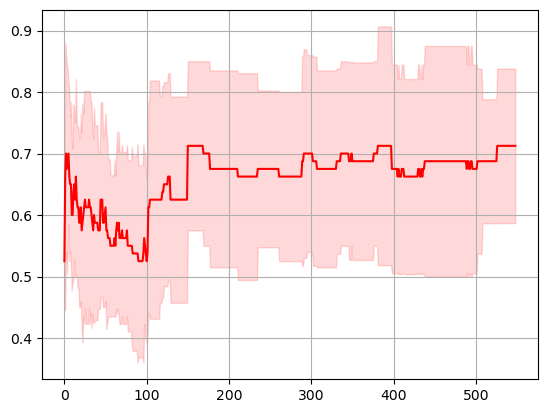

In [ ]:
acc_per_feature = []
std_per_feature = []

for index, feature_name in enumerate(sorted_names,start=1):

    input_features_names = sorted_names[:index]
    input_features_index = [data.columns.get_loc(c) for c 
                      in input_features_names if c in data]
    best_model.fit(X_train[:, input_features_index], y_train)
    scores = cross_val_score(
                        estimator=best_model,
                        X=X_train[:, input_features_index],
                        y=y_train,
                        cv=10,
                        n_jobs=-1
                        )
    acc_per_feature.append(np.mean(scores))
    std_per_feature.append(np.std(scores))

plt.plot(
        range(0, len(sorted_names)),
        acc_per_feature,
        color='red'
        ) 

plt.fill_between(
                range(0, len(sorted_names)),
                np.array(acc_per_feature) + np.array(std_per_feature),
                np.array(acc_per_feature) - np.array(std_per_feature),
                alpha=0.15,
                color='red'
                )

plt.grid()

### XGBoosting

### TPOT

In [ ]:
pipeline_optimizer = TPOTClassifier()

In [ ]:
pipeline_optimizer = TPOTClassifier(
                                    generations=5,
                                    population_size=int(X.shape[0]*0.4),
                                    cv=10,
                                    random_state=10,
                                    verbosity=3,
                                    n_jobs=-1
                                    )

In [ ]:
pipeline_optimizer.fit(X_train, y_train)

32 operators have been imported by TPOT.


Optimization Progress:   0%|          | 0/240 [00:00<?, ?pipeline/s]

_pre_test decorator: _random_mutation_operator: num_test=0 Negative values in data passed to MultinomialNB (input X).

Generation 1 - Current Pareto front scores:

-1	0.75	DecisionTreeClassifier(input_matrix, DecisionTreeClassifier__criterion=entropy, DecisionTreeClassifier__max_depth=2, DecisionTreeClassifier__min_samples_leaf=9, DecisionTreeClassifier__min_samples_split=6)
_pre_test decorator: _random_mutation_operator: num_test=0 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 89.
_pre_test decorator: _random_mutation_operator: num_test=0 Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty..
_pre_test decorator: _random_mutation_operator: num_test=0 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required by DecisionTreeClassifier..

Generation 2 - Current Pareto front scores:

-1	0.75	DecisionTreeClassifier(input_matrix, DecisionTreeClassifier__criterion=entropy, DecisionTreeClassifier__max_depth=2, DecisionTreeClassifier_

In [ ]:
print(pipeline_optimizer.score(X_test, y_test))